**Timeseries Forecasting:**
- Time series forecasting for multiple stocks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.ensemble import AdaBoostRegressor

**reading the data:**

In [2]:
df = web.DataReader(['F', "AAPL", "GOOGL"], 'stooq')["High"]
df.head()

Symbols,F,AAPL,GOOGL
Date,,,
2025-07-11,11.86,212.13,181.430
2025-07-10,11.97,213.48,178.429
2025-07-09,11.90,211.33,179.440
2025-07-08,11.85,211.43,177.950
2025-07-07,11.79,216.23,179.297


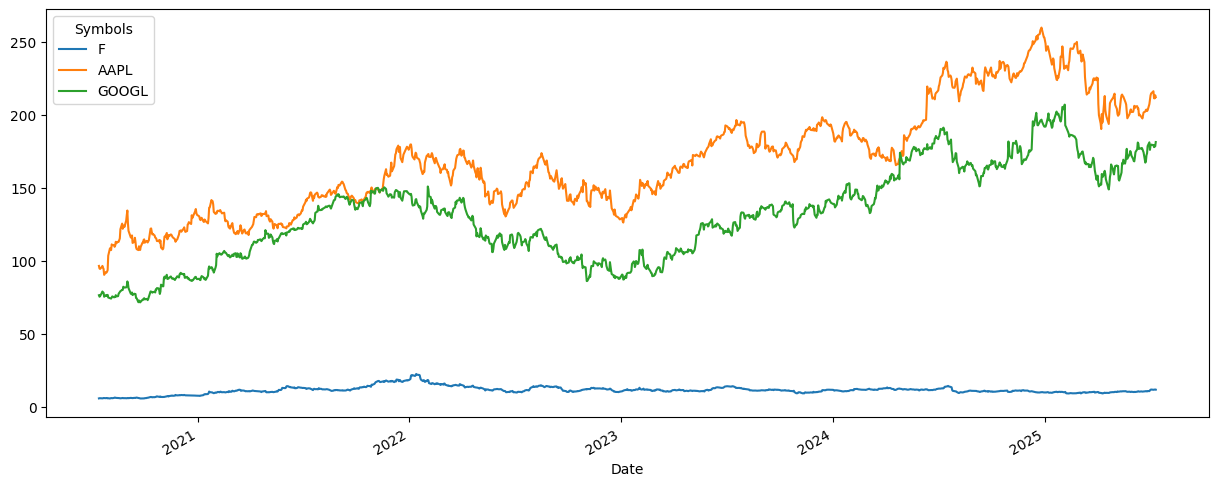

In [3]:
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

This time we need to make sure to preserve the stock symbol information while reordering:

In [4]:
df_melted = df.copy()
df_melted["date"] = df_melted.index

In [7]:
df_melted = df_melted.melt(id_vars = "date", value_name = "high").sort_values(["Symbols", "date"])
df_melted = df_melted[["Symbols","date","high"]]
df_melted.head()


,Symbols,date,high
2507,AAPL,2020-07-15,96.6036
2506,AAPL,2020-07-16,94.8091
2505,AAPL,2020-07-17,94.5589
2504,AAPL,2020-07-20,95.8754
2503,AAPL,2020-07-21,96.6056


**Create training data sample:**

In [8]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date", max_timeshift= 20, min_timeshift=5)

c:\Users\blais\Documents\ML\venv2\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s]


In [9]:
df_rolled.head()

,Symbols,date,high,id
0,AAPL,2020-07-15,96.6036,"(AAPL, 2020-07-22 00:00:00)"
1,AAPL,2020-07-16,94.8091,"(AAPL, 2020-07-22 00:00:00)"
2,AAPL,2020-07-17,94.5589,"(AAPL, 2020-07-22 00:00:00)"
3,AAPL,2020-07-20,95.8754,"(AAPL, 2020-07-22 00:00:00)"
4,AAPL,2020-07-21,96.6056,"(AAPL, 2020-07-22 00:00:00)"


Extract Features:

In [10]:
X = extract_features(df_rolled.drop("Symbols", axis=1),
                     column_id = "id", column_sort="date", column_value="high",
                     impute_function = impute, show_warnings=False)

Feature Extraction: 100%|██████████| 40/40 [01:21<00:00,  2.04s/it]


In [11]:
X.head()

high__variance_larger_than_standard_deviation  ...  high__mean_n_absolute_max__number_of_maxima_7
AAPL 2020-07-22                                            0.0  ...                                     125.576143
     2020-07-23                                            0.0  ...                                     125.576143
     2020-07-24                                            1.0  ...                                      95.472214
     2020-07-27                                            1.0  ...                                      95.472214
     2020-07-28                                            1.0  ...                                      95.472214

[5 rows x 783 columns]

We make the data a bit easier to work with by giving them a multi-index instead of a tuple index:

In [14]:
X = X.set_index([X.index.map(lambda x: x[0]), X.index.map(lambda x: x[1])], drop=True)
X.index.names = ["Symbols","last_date"]

In [15]:
X.head()

high__variance_larger_than_standard_deviation  ...  high__mean_n_absolute_max__number_of_maxima_7
Symbols last_date                                                  ...                                               
AAPL    2020-07-22                                            0.0  ...                                     125.576143
        2020-07-23                                            0.0  ...                                     125.576143
        2020-07-24                                            1.0  ...                                      95.472214
        2020-07-27                                            1.0  ...                                      95.472214
        2020-07-28                                            1.0  ...                                      95.472214

[5 rows x 783 columns]

In [16]:
X.loc["AAPL", pd.to_datetime("2020-07-22")]

high__variance_larger_than_standard_deviation                0.000000
high__has_duplicate_max                                      0.000000
high__has_duplicate_min                                      0.000000
high__has_duplicate                                          0.000000
high__sum_values                                           573.815600
                                                              ...    
high__permutation_entropy__dimension_5__tau_1                0.693147
high__permutation_entropy__dimension_6__tau_1               -0.000000
high__permutation_entropy__dimension_7__tau_1                2.708050
high__query_similarity_count__query_None__threshold_0.0      0.000000
high__mean_n_absolute_max__number_of_maxima_7              125.576143
Name: (AAPL, 2020-07-22 00:00:00), Length: 783, dtype: float64

**prediction:**
- here's what the next line does:
  - For each stock symbol separately:
    - sort by date
    - take the high value
    - shift 1 time step in the future
    - bring into the same multi-index format as above

In [17]:
df_melted

,Symbols,date,high
2507,AAPL,2020-07-15,96.6036
2506,AAPL,2020-07-16,94.8091
2505,AAPL,2020-07-17,94.5589
2504,AAPL,2020-07-20,95.8754
2503,AAPL,2020-07-21,96.6056
...,...,...,...
2512,GOOGL,2025-07-07,179.2970
2511,GOOGL,2025-07-08,177.9500
2510,GOOGL,2025-07-09,179.4400
2509,GOOGL,2025-07-10,178.4290


In [20]:
y = df_melted.groupby("Symbols").apply(lambda x: x.set_index("date")["high"].shift(-1)).T.unstack()

C:\Users\blais\AppData\Local\Temp\ipykernel_19216\2586903907.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y = df_melted.groupby("Symbols").apply(lambda x: x.set_index("date")["high"].shift(-1)).T.unstack()


quick consistency check:

In [21]:
y["AAPL", pd.to_datetime("2020-07-15")], df.loc[pd.to_datetime("2020-07-16"),"AAPL"]

(94.8091, 94.8091)

In [22]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

Then, splitting into train and test samples works in priciple the same as with a single identifier but this time we have a multi-index symbol date

In [23]:
X_train = X.loc[(slice(None), slice(None, "2020")), :]
X_test = X.loc[(slice(None), slice("2021", "2022")), :]

y_train = y.loc[(slice(None), slice(None, "2020"))]
y_test = y.loc[(slice(None), slice("2021", "2022"))]

In [24]:
X_train_selected = select_features(X_train, y_train)

we are training a regressor for each of the stocks separately

In [25]:
adas = {stock: AdaBoostRegressor() for stock in ["AAPL", "F", "GOOGL"]}

for stock, ada in adas.items():
    ada.fit(X_train_selected.loc[stock], y_train.loc[stock])

In [26]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.concat({
    stock: pd.Series(adas[stock].predict(X_test_selected.loc[stock]), index=X_test_selected.loc[stock].index)
    for stock in adas.keys()
})
y_pred.index.names = ["Symbols", "last_date"]

<AxesSubplot:xlabel='last_date'>

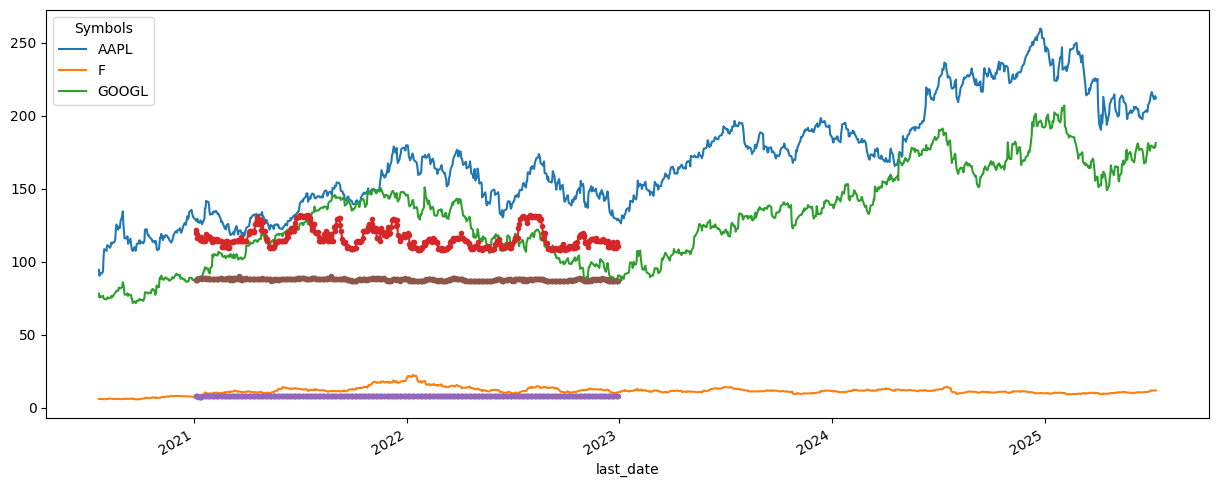

In [27]:
plt.figure(figsize=(15, 6))

y.unstack("Symbols").plot(ax=plt.gca())
y_pred.unstack("Symbols").plot(ax=plt.gca(), legend=None, marker=".")